In [1]:
from dotenv import load_dotenv
from service.s3_storage_service import S3StorageService
from storage.s3_client import S3Client

load_dotenv() # Load environment variable with the bucket name. 
s3_client = S3Client().get_client()
s3_service = S3StorageService(s3_client)

## Step 1: Define functions for data retrieval and storage in a dataframe
### This process involves downloading the data from the URL, processing and storing it in a dataframe.

In [2]:
def generate_csv_urls(station_guid, measurement_interval="1d"):
    if measurement_interval == "15min":
        filename = "15min_measurements_links.json"
    elif measurement_interval == "1d":
        filename = "1d_measurements_links.json"
    else:
        raise ValueError("Invalid measurement interval. Choose either '15min' or '1d'.")
    
    return s3_service.load_json_from_s3(f"flood_stations/{station_guid}/{filename}")

In [3]:
def fetch_latest_measurement_date(url):
    """ Fetch the latest measurement date from the given URL. """
    try:
        # Assume the URL returns CSV data with a 'date' column
        df = pd.read_csv(url + "?latest")
        latest_date = pd.to_datetime(df['dateTime'].max())
        return latest_date
    except Exception as e:
        print(f"Failed to fetch or parse data from {url}: {e}")
        return None

def check_station_viability(measurements, days=14):
    """ Check which measurements are up-to-date within the specified number of days. """
    viable_measurements = []
    cutoff_date = datetime.now() - timedelta(days=days)
    
    for measurement in measurements:
        latest_date = fetch_latest_measurement_date(measurement['link'])
        if latest_date and latest_date >= cutoff_date:
            viable_measurements.append(measurement['type'])
        else:
            print(f"Measurement {measurement['type']} is outdated (last update: {latest_date})")
    
    return viable_measurements


## Generate a loop to verify the state of available datasets. 

In [16]:
all_stations_guids_refs = s3_service.load_json_from_s3("flood_stations_metadata/confirmed_guids_refs.json")
number_of_stations = 0
for item in all_stations_guids_refs:
    links = generate_csv_urls(item['guid'])
    viable_measurements = check_station_viability(links)
    print(f"Station {item['guid']}")
    print("Viable measurements:", viable_measurements)
    if 'fmean' in viable_measurements:
        print(f"Station {item['guid']} is viable for processing.")
        number_of_stations += 1

    else:
        print(f"Station {item['guid']} is not viable for processing.")
    
print(f"Total number of stations: {number_of_stations}")
    
   

NameError: name 'timedelta' is not defined

In [4]:
def append_guid_to_s3(s3_service, new_data, key):
    """ Append GUID to the JSON file in the S3 bucket """
    try:
        # Load the existing data
        data = s3_service.load_json_from_s3(key)
    except EnvironmentError:
        data = []  # Assume empty list if the file doesn't exist

    # Append new data
    data.append(new_data)

    # Save updated data back to S3
    s3_service.save_json_to_s3(key, data)

In [5]:
from datetime import datetime, timedelta

def generate_multi_year_dataframe(url, number_of_years=14):
    end_date = datetime.now()  # Today's date
    start_date = end_date - timedelta(days=365 * number_of_years)  # Date 12 years ago
    
    # Format dates for the URL
    formatted_end_date = end_date.strftime('%Y-%m-%d')
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    
    # Construct the download URL
    download_url = f"{url}?min-date={formatted_start_date}&max-date={formatted_end_date}&_limit=2000000"
    
    print(f"Downloading data from {download_url}")
    # Load the data into a DataFrame
    df = pd.read_csv(download_url, parse_dates=['dateTime'], low_memory=False, on_bad_lines='skip')
    
    return df

In [6]:
from dateutil.parser import parse

def generate_learning_dataframe(input_df, measurement_type):
    # Convert 'date' column to datetime, attempting to parse any recognized format
    input_df['date'] = pd.to_datetime(input_df['date'], errors='coerce')

    # Group by date and aggregate
    aggregated_data = input_df.groupby('date')['value'].agg(['min', 'max', 'mean'])

    # Rename the columns to include the measurement type
    aggregated_data.columns = [f'{measurement_type}{col}' for col in aggregated_data.columns]

    return aggregated_data.reset_index()  # Keep 'date' as a column, not an index


In [7]:
import pandas as pd

def merge_dataframes(links):
    final_df = None
    for link_item in links:
        print(f"Processing data from {link_item['link']}")
        # Generate the initial dataframe for 12 years of data
        df = generate_multi_year_dataframe(link_item['link'])
        
        # Generate the learning dataframe with aggregated min, max, and mean
        learning_df = generate_learning_dataframe(df, link_item['type'][0])
        
        # Set the index right before the merge
        learning_df.set_index('date', inplace=True)
        
        # Merge with the final dataframe
        if final_df is None:
            final_df = learning_df
        else:
            final_df = final_df.join(learning_df, how='outer')
    
    return final_df


In [8]:
import os
def process_stations(all_stations_guids_refs, s3_service):
    number_of_stations = 0
    for item in all_stations_guids_refs:
        links = generate_csv_urls(item['guid'], "15min")
        viable_measurements = check_station_viability(links)
        print(f"Station {item['guid']}")
        print("Viable measurements:", viable_measurements)

        if len(viable_measurements) == 3:
            print(f"Station {item['guid']} is viable for processing with all measurements.")
            number_of_stations += 1

            # Generate the dataframe
            df = merge_dataframes(links)  # Assuming this function already exists

            # Define the local file path for the DataFrame
            local_directory = f"data/{item['guid']}/"
            file_path = os.path.join(local_directory, 'dataframe.csv')
            
            # Create the directory if it does not exist
            os.makedirs(local_directory, exist_ok=True)
            
            # Save the DataFrame to a CSV file locally
            df.to_csv(file_path, index=True)

            append_guid_to_s3(s3_service, item, "flood_stations_metadata/processed_guids_refs.json")
            print(f"Station {item['guid']} processed successfully.")
        else:
            print(f"Station {item['guid']} is not viable for processing.")

    print(f"Total number of stations with all measurements: {number_of_stations}")

## Loop through all links available under the station. Download the 15min interval datasets, calculate daily mean, max and min values and store them in a dataframe.
## Repeat that for all stations tha produce up-to-date information

In [80]:
all_stations_guids_refs = s3_service.load_json_from_s3("flood_stations_metadata/confirmed_guids_refs.json")

process_stations(all_stations_guids_refs, s3_service)

Measurement finst is outdated (last update: 2023-11-23 06:15:00)
Station d7896c1f-b892-4272-b78a-9bb4d5a53c5b
Viable measurements: ['linst', 'rain']
Station d7896c1f-b892-4272-b78a-9bb4d5a53c5b is not viable for processing.
Measurement finst is outdated (last update: 2024-03-01 07:00:00)
Station 98e517e4-c709-4d16-b334-251677af1750
Viable measurements: ['linst', 'rain']
Station 98e517e4-c709-4d16-b334-251677af1750 is not viable for processing.
Failed to fetch or parse data from http://environment.data.gov.uk/hydrology/id/measures/c5b924d1-9dcf-49d9-97ef-c097054086af-flow-i-900-m3s-qualified/readings.csv: No columns to parse from file
Measurement finst is outdated (last update: None)
Measurement rain is outdated (last update: 2024-03-17 10:15:00)
Station c5b924d1-9dcf-49d9-97ef-c097054086af
Viable measurements: ['linst']
Station c5b924d1-9dcf-49d9-97ef-c097054086af is not viable for processing.
Station f357a614-cd56-4425-a685-133aa736e0c8
Viable measurements: ['finst', 'linst', 'rain']


## Step 2: Define functions for data processing, including normalisation.

### Load the data from local filesystem and store it in a dataframe, using date as an index.

In [9]:
def load_csv_as_dataframe(file_path):
    try:
        # Load the CSV file, using the first column as the index of the DataFrame
        df = pd.read_csv(file_path, index_col=0)
        print(f"Data loaded successfully from {file_path}")

        # Create a DataFrame without the last three columns ('rmin', 'rmax', 'rmean')
        if 'rmin' in df.columns and 'rmax' in df.columns and 'rmean' in df.columns:
            df_without_r = df.drop(columns=['rmin', 'rmax', 'rmean'])
        else:
            df_without_r = df

        return df, df_without_r
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        return None, None

In [94]:
file_path = "data/7998bf73-641d-4084-b00c-ca6989f2ba2b/dataframe.csv"
df, df_without_r = load_csv_as_dataframe(file_path)
print(df.head())
print(df_without_r.head())

Data loaded successfully from data/7998bf73-641d-4084-b00c-ca6989f2ba2b/dataframe.csv
             fmin   fmax     fmean   lmin   lmax     lmean  rmin  rmax  rmean
date                                                                         
2010-04-24  0.492  0.521  0.503458  0.103  0.107  0.104583   NaN   NaN    NaN
2010-04-25  0.485  0.507  0.495969  0.102  0.105  0.103552   NaN   NaN    NaN
2010-04-26  0.471  0.499  0.482375  0.100  0.104  0.101625   NaN   NaN    NaN
2010-04-27  0.457  0.485  0.471365  0.098  0.102  0.100052   NaN   NaN    NaN
2010-04-28  0.457  0.478  0.465823  0.098  0.101  0.099260   NaN   NaN    NaN
             fmin   fmax     fmean   lmin   lmax     lmean
date                                                      
2010-04-24  0.492  0.521  0.503458  0.103  0.107  0.104583
2010-04-25  0.485  0.507  0.495969  0.102  0.105  0.103552
2010-04-26  0.471  0.499  0.482375  0.100  0.104  0.101625
2010-04-27  0.457  0.485  0.471365  0.098  0.102  0.100052
2010-04-28  0.

### Trim the dataframe so it does not have any NaN values at the start. It is because certain values have been recorded much earlier than the others. 

In [24]:
def trim_dataframe_start(df):
    # Find the index of the first non-NaN value in each column
    first_valid_indices = df.apply(pd.Series.first_valid_index)
    
    # Find the maximum of these indices to get the latest start point across all columns
    latest_start_index = max(first_valid_indices)
    
    # Trim the DataFrame to start from this index
    trimmed_df = df.loc[latest_start_index:]
    
    return trimmed_df

df_trimmed = trim_dataframe_start(df)
print(df_trimmed.head())

df_without_r_trimmed = trim_dataframe_start(df_without_r)
print(df_without_r_trimmed.head())


NameError: name 'df' is not defined

### Fill empty values with either zero (for rainfall) or mean value (for other columns).

In [25]:
def fill_empty_values(df):
    """
    Fill empty values in all columns of the DataFrame with the mean of their respective columns.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with filled values.
    """
    # Fill empty values with the mean of the column for each column in the DataFrame
    df_filled = df.fillna(df.mean())
    
    return df_filled


def save_to_csv(df, guid, with_rainfall=True):
    rainfall = 'rainfall' if with_rainfall else 'no_rainfall'
    file_path = f"data/{guid}/dataframe_{rainfall}.csv"
    df.to_csv(file_path)
    print(f"Data saved to {file_path}")

In [106]:
processed_guid_refs = s3_service.load_json_from_s3("flood_stations_metadata/processed_guids_refs.json")

for item in processed_guid_refs:
    guid = item['guid']
    file_path = f"data/{guid}/dataframe.csv"
    df, df_without_r = load_csv_as_dataframe(file_path)
    df_trimmed = trim_dataframe_start(df)
    df_without_r_trimmed = trim_dataframe_start(df_without_r)
    
    df_filled = fill_empty_values(df_trimmed)
    df_without_r_filled = fill_empty_values(df_without_r_trimmed)
    
    save_to_csv(df_filled, guid)
    save_to_csv(df_without_r_filled, guid, with_rainfall=False)

Data loaded successfully from data/65b8dffb-ee80-4b9b-b2ba-4670d2ba06c2/dataframe.csv
Data saved to data/65b8dffb-ee80-4b9b-b2ba-4670d2ba06c2/dataframe_rainfall.csv
Data saved to data/65b8dffb-ee80-4b9b-b2ba-4670d2ba06c2/dataframe_no_rainfall.csv
Data loaded successfully from data/b6cc814c-4b13-4645-89ee-25e8e3d79dc0/dataframe.csv
Data saved to data/b6cc814c-4b13-4645-89ee-25e8e3d79dc0/dataframe_rainfall.csv
Data saved to data/b6cc814c-4b13-4645-89ee-25e8e3d79dc0/dataframe_no_rainfall.csv
Data loaded successfully from data/2d88723b-45f6-46e2-b662-6b2573a7fba7/dataframe.csv
Data saved to data/2d88723b-45f6-46e2-b662-6b2573a7fba7/dataframe_rainfall.csv
Data saved to data/2d88723b-45f6-46e2-b662-6b2573a7fba7/dataframe_no_rainfall.csv
Data loaded successfully from data/a5bf03e9-e63a-4cd5-8bc9-ab64c03808b9/dataframe.csv
Data saved to data/a5bf03e9-e63a-4cd5-8bc9-ab64c03808b9/dataframe_rainfall.csv
Data saved to data/a5bf03e9-e63a-4cd5-8bc9-ab64c03808b9/dataframe_no_rainfall.csv
Data loaded 

### Normalise all values in the dataframe to prepare them for the training process. Keep the scaler for later use.

In [35]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def prepare_data_for_training(df, n_input, n_output, batch_size, target_column):
    """
    Prepares data for training by normalizing and creating TimeseriesGenerators.
    Handles missing data by filling it with the column mean.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        n_input (int): Number of input time steps to use for each output.
        n_output (int): Number of output time steps.
        batch_size (int): Batch size for the generators.
        target_column (str): The name of the target column for prediction.

    Returns:
        tuple: Tuple containing train_generator, test_generator, scaler, n_features,
               and additional info like split index and column target index.
    """
    if target_column not in df.columns:
        raise ValueError(f"Target column {target_column} not found in DataFrame.")

    # Handle missing data
    df_filled = df.fillna(df.mean())

    # Normalize the data
    data = df_filled.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_normalized = scaler.fit_transform(data)

    # Ensure sufficient data for splits
    if len(data_normalized) < n_input + n_output:
        raise ValueError("Not enough data to accommodate the input and output lengths.")

    # Split data into training and test sets
    split_percent = 0.90
    split_index = int(len(data_normalized) * split_percent)
    train_data = data_normalized[:split_index]
    test_data = data_normalized[split_index - n_input:]

    # n_features is the number of columns in the dataframe
    n_features = df.shape[1]

    # Determine the index of the target column
    target_index = df.columns.get_loc(target_column)

    # Create TimeseriesGenerators
    train_generator = TimeseriesGenerator(train_data, train_data[:, target_index],
                                          length=n_input, batch_size=batch_size)
    test_generator = TimeseriesGenerator(test_data, test_data[:, target_index],
                                         length=n_input, batch_size=batch_size)

    return train_generator, test_generator, scaler, n_features, split_index, target_index




### Define functions for model training and evaluation.

In [0]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from math import sqrt
# import numpy as np
# 
# def evaluate_model_performance(model, test_generator, scaler, n_output):
#     try:
#         # Get predictions from the model
#         predictions = model.predict(test_generator)
#         
#         # Collect actuals directly from the generator
#         actuals = []
#         for _, y in test_generator:
#             actuals.extend(y)
#         y_test = np.array(actuals)
# 
#         # Reshape predictions to match the actuals format
#         predictions_reshaped = predictions.reshape(-1, n_output)
#         y_test_reshaped = y_test.reshape(-1, n_output)
# 
#         # Inverse scale predictions and actuals if scaler is applied to multi-dimensional data
#         predictions_inverse = scaler.inverse_transform(predictions_reshaped)
#         actuals_inverse = scaler.inverse_transform(y_test_reshaped)
# 
#         # Calculate RMSE and MAE per output step
#         rmse_values = []
#         mae_values = []
#         for i in range(predictions_inverse.shape[0]):  # iterate over each batch set
#             for j in range(predictions_inverse.shape[1]):  # iterate over each timestep
#                 rmse = sqrt(mean_squared_error([actuals_inverse[i, j]], [predictions_inverse[i, j]]))
#                 mae = mean_absolute_error([actuals_inverse[i, j]], [predictions_inverse[i, j]])
#                 rmse_values.append(rmse)
#                 mae_values.append(mae)
# 
#         average_rmse = np.mean(rmse_values)
#         average_mae = np.mean(mae_values)
# 
#         return average_rmse, average_mae
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return None, None

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def evaluate_model_performance(model, test_generator, n_output):
    # Generate predictions for the test data
    predictions = model.predict(test_generator)
    predictions_reshaped = predictions.reshape(-1, 1)

   # Collect the actual y values from the test generator
    actuals = []
    for _, y in test_generator:
        actuals.extend(y)
    y_test = np.array(actuals)

    y_test_reshaped = y_test.reshape(-1, 1)
    
    # Assuming you have lists or need to ensure these are numpy arrays
    true_values = np.array(actuals)  # Convert to NumPy array if it's not already
    predictions = np.array(predictions)  # Convert to NumPy array if it's not already

    # Calculate RMSE for each prediction window
    rmse_values = []
    rmae_values = []
    
    for i in range(len(true_values) - n_output):
        # Extract the actual values for the next 7 days
        actuals_for_window = true_values[i:i+n_output]
        
        # Extract the corresponding set of predictions
        predictions_for_window = predictions[i]
        
        # Calculate the RMSE for this window and append to our list
        rmse = sqrt(mean_squared_error(actuals_for_window, predictions_for_window))
        rmse_values.append(rmse)
        rmae = mean_absolute_error(actuals_for_window, predictions_for_window)
        rmae_values.append(rmae)

    # Calculate the average RMSE across all windows
    average_rmse = np.mean(rmse_values)
    average_mae = np.mean(rmae_values)
    print(f"Average RMSE across all sliding windows: {average_rmse}")
    print(f"Average MAE across all sliding windows: {average_mae}")
    return average_rmse, average_mae, rmse_values, rmae_values


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
import os
import json

def train_model(train_generator, test_generator, n_input, n_features, n_output, scaler, model_type='LSTM', learning_rate=0.001, epochs=10, patience=10, dropout_rate=0.2):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(128, return_sequences=False, input_shape=(n_input, n_features)))
    elif model_type == 'GRU':
        model.add(GRU(128, return_sequences=False, input_shape=(n_input, n_features)))
    else:
        raise ValueError("Unsupported model type. Choose 'LSTM' or 'GRU'.")

    model.add(Dropout(dropout_rate))
    model.add(Dense(n_output))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(delta=0.005))

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)

    history = model.fit(train_generator, validation_data=test_generator, epochs=epochs, callbacks=[early_stopping])

    # Evaluate the model's performance
    average_rmse, average_mae, rmse, rmae = evaluate_model_performance(model, test_generator,  n_output)

    # Collect performance statistics
    performance_stats = {
        'history': history.history,
        'final_val_loss': history.history['val_loss'][-1],
        'average_rmse': average_rmse,
        'average_mae': average_mae
    }

    return performance_stats, model, rmse, rmae

### Define functions for generating metadata and saving the model to S3.

In [29]:
from datetime import datetime

def generate_metadata(performance_stats, n_input, n_output, with_rainfall, model_type, station_guid, target_column, batch_size, learning_rate, epochs_trained,  model_save_path='path/to/model', measurement_interval="1d"):
    metadata = {
        'station_guid': station_guid,
        'n_input': n_input,
        'n_output': n_output,
        'measurement_interval': measurement_interval,
        'model_type': model_type,
        'contains_rainfall': with_rainfall,
        'average_rmse': performance_stats['average_rmse'],
        'average_mae': performance_stats['average_mae'],
        'final_train_loss': performance_stats['history']['loss'][-1],
        'final_val_loss': performance_stats['history']['val_loss'][-1],
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'epochs_trained': epochs_trained,
        'timestamp': datetime.now().isoformat(),
        'model_save_path': model_save_path,
        'target_column': target_column
    }
    return metadata


In [30]:
from matplotlib import pyplot as plt
import shutil
import os
import joblib
from tensorflow.keras.models import save_model
from tensorflow.keras import backend as K

def generate_model_path(metadata):
    rainfall_status = 'rainfall' if metadata['contains_rainfall'] else 'no_rainfall'
    # Updated directory names to be more descriptive and aligned with the requirements
    return f"flood_stations/{metadata['station_guid']}/models/{metadata['target_column']}/{metadata['measurement_interval']}_{metadata['model_type']}_{rainfall_status}/"

def plot_and_save_metrics(rmse_values, mae_values, model_storage_key, s3_service):
    # Plot RMSE
    plt.figure(figsize=(10, 6))
    plt.plot(rmse_values, label='RMSE per Window', color='blue')
    plt.title('RMSE for Each Sliding Window Prediction')
    plt.xlabel('Window Start Day')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    rmse_plot_path = f"tmp/rmse_plot.png"
    plt.savefig(rmse_plot_path)
    plt.close()
    
    # Upload RMSE plot to S3
    s3_service.save_file_to_s3(model_storage_key + 'rmse_plot.png', rmse_plot_path)
    os.remove(rmse_plot_path)  # Clean up the local file

    # Plot MAE
    plt.figure(figsize=(10, 6))
    plt.plot(mae_values, label='MAE per Window', color='red')
    plt.title('MAE for Each Sliding Window Prediction')
    plt.xlabel('Window Start Day')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    mae_plot_path = f"tmp/mae_plot.png"
    plt.savefig(mae_plot_path)
    plt.close()
    
    # Upload MAE plot to S3
    s3_service.save_file_to_s3(model_storage_key + 'mae_plot.png', mae_plot_path)
    os.remove(mae_plot_path)  # Clean up the local file

def save_to_s3_and_cleanup(s3_service, model, scaler, performance_stats, metadata, rmse_values, mae_values, model_id):
    model_storage_key = generate_model_path(metadata)
    
    # Save plots for RMSE and MAE
    plot_and_save_metrics(rmse_values, mae_values, model_storage_key, s3_service)

    # Ensure directory exists for storing temporary files
    model_dir = f"tmp/{model_id}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Save the model in HDF5 format
    save_model_path = os.path.join(model_dir, 'model.keras')
    model.save(save_model_path)  
    
    # Upload the model file to S3
    s3_service.save_file_to_s3(model_storage_key + 'model.keras', save_model_path)

    # Save the scaler using joblib
    scaler_path = os.path.join(model_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    s3_service.save_file_to_s3(model_storage_key + 'scaler.pkl', scaler_path)

    # Save Performance Metrics and Metadata as JSON
    performance_metrics_path = os.path.join(model_dir, 'performance_metrics.json')
    metadata_path = os.path.join(model_dir, 'metadata.json')
    with open(performance_metrics_path, 'w') as pm_file:
        json.dump(performance_stats, pm_file)
    with open(metadata_path, 'w') as md_file:
        json.dump(metadata, md_file)
    s3_service.save_file_to_s3(model_storage_key + 'performance_metrics.json', performance_metrics_path)
    s3_service.save_file_to_s3(model_storage_key + 'metadata.json', metadata_path)

    # Clean up local files to free up space
    shutil.rmtree(model_dir)
    K.clear_session()  # Clear the TensorFlow session to free up resources

## Step 3: Define a function to train models for all stations and save them to S3.

In [36]:


def train_models(stations_guids_refs, s3_service, n_input=56, n_output=7, batch_size=32, learning_rate=0.001, epochs=10, patience=10, dropout_rate=0.2):
    for item in stations_guids_refs:
        guid = item['guid']
        # Assuming CSVs are stored under the directory with the GUID
        df_no_rainfall = pd.read_csv(f"data/{guid}/dataframe_no_rainfall.csv", index_col=0)
        df_rainfall = pd.read_csv(f"data/{guid}/dataframe_rainfall.csv", index_col=0)


        # Prepare data for training
        # This assumes the dataframe is already preprocessed and ready for generating training data
        target_columns = ['lmin', 'lmax']
        data_variants = [(df_rainfall, 'rainfall'), (df_no_rainfall, 'no_rainfall')]

        for df, rainfall_status in data_variants:
            for target_column in target_columns:
                print(f"Training model for {guid} on {target_column} with {rainfall_status}")

                # Generate data generators
                train_gen, test_gen, scaler, n_features, split_index, target_index = prepare_data_for_training(
                    df, n_input, n_output, batch_size, target_column
                )
                
                # Train the model
                model_type = 'LSTM'  # Can also loop over or configure to use 'GRU'
                performance_stats, model, rmse, rmae = train_model(
                    train_gen, test_gen, n_input, n_features, n_output, scaler, model_type=model_type, learning_rate=learning_rate,
                    epochs=epochs, patience=patience, dropout_rate=dropout_rate
                )

                # Generate metadata for the model
                metadata = generate_metadata(performance_stats, n_input, n_output, rainfall_status == 'rainfall', model_type, guid, target_column, batch_size, learning_rate, epochs, model_save_path='path/to/model', measurement_interval="1d")

                # Save everything to S3
                model_id = f"{model_type.lower()}_{rainfall_status}_{target_column}"
                save_to_s3_and_cleanup(s3_service, model, scaler, performance_stats, metadata,rmse, rmae, model_id)


        

## Train the models for all stations with all measurements available.

In [37]:
guids_refs = s3_service.load_json_from_s3("flood_stations_metadata/processed_guids_1.json")

train_models(guids_refs, s3_service)


Training model for 435a330f-ef10-48ce-babf-7b08ad9d45c5 on lmin with rainfall


2024-04-19 23:21:34.525822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 23:21:34.650660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 23:21:34.650691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 23:21:34.652644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 23:21:34.652673: I external/local_xla/xla/stream_executor

Epoch 1/10


2024-04-19 23:21:36.062912: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-19 23:21:36.461035: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa51819e4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-19 23:21:36.461055: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-19 23:21:36.469665: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713565296.533041    3541 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 [==============================] - 2s 7ms/step - loss: 1.2257e-04 - val_loss: 1.7534e-04
Epoch 2/10
142/142 [==============================] - 1s 6ms/step - loss: 8.3838e-05 - val_loss: 1.5153e-04
Epoch 3/10
142/142 [==============================] - 1s 6ms/step - loss: 8.0784e-05 - val_loss: 1.4887e-04
Epoch 4/10
142/142 [==============================] - 1s 6ms/step - loss: 7.3481e-05 - val_loss: 1.4893e-04
Epoch 5/10
142/142 [==============================] - 1s 6ms/step - loss: 6.7939e-05 - val_loss: 1.5587e-04
Epoch 6/10
142/142 [==============================] - 1s 6ms/step - loss: 6.6797e-05 - val_loss: 1.3627e-04
Epoch 7/10
142/142 [==============================] - 1s 6ms/step - loss: 6.4698e-05 - val_loss: 1.3460e-04
Epoch 8/10
142/142 [==============================] - 1s 6ms/step - loss: 6.3810e-05 - val_loss: 1.2821e-04
Epoch 9/10
142/142 [==============================] - 1s 6ms/step - loss: 6.2040e-05 - val_loss: 1.3418e-04
Epoch 10/10
16/16 [====================

## Step 4: Define a function to load the model from S3 and make predictions.

In [2]:
from tensorflow.keras.models import load_model
import joblib

def load_model_from_local_path(model_path):
    model = load_model(model_path)
    return model



def load_scaler_from_path(scaler_path):
    scaler = joblib.load(scaler_path)
    return scaler

def make_predictions(model, scaled_test_data):
    predictions = model.predict(scaled_test_data)
    return predictions


2024-04-22 10:18:59.059629: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 10:18:59.440489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 10:18:59.440517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 10:18:59.474391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 10:18:59.541925: I tensorflow/core/platform/cpu_feature_guar

In [12]:
import os
import joblib
from tensorflow.keras.models import load_model

# Function to download and load the model
def download_and_load_model(s3_service, model_key, local_path):
    local_model_path = os.path.join(local_path, 'model.keras')  # Assuming .keras format for simplicity
    s3_service.download_file_from_s3(model_key, local_model_path)  # Download the model file
    model = load_model(local_model_path)  # Load the model
    return model

# Function to download and load the scaler
def download_and_load_scaler(s3_service, scaler_key, local_path):
    scaler_path = os.path.join(local_path, 'scaler.pkl')
    s3_service.download_file_from_s3(scaler_key, scaler_path)  # Download the scaler file
    scaler = joblib.load(scaler_path)  # Load the scaler
    return scaler

# Model and scaler keys
model_key = 'flood_stations/b805b347-4665-4986-ba35-43d67542a5c0/models/lmax/1d_LSTM_no_rainfall/model.keras'
scaler_key = 'flood_stations/b805b347-4665-4986-ba35-43d67542a5c0/models/lmax/1d_LSTM_no_rainfall/scaler.pkl'
model_key_2 = 'flood_stations/00dfeaa4-34bd-4975-967a-b11e5d86520e/models/lmax/1d_LSTM_no_rainfall/model.keras'
scaler_key_2 = 'flood_stations/00dfeaa4-34bd-4975-967a-b11e5d86520e/models/lmax/1d_LSTM_no_rainfall/scaler.pkl'
model_key_3 = 'flood_stations/08a56e86-d214-4288-8726-8de31eb55766/models/lmax/1d_LSTM_no_rainfall/model.keras'



# Local paths for model and scaler
local_model_dir = 'local_model'
local_scaler_dir = 'local_model'  # You can use the same local directory for simplicity

# Ensure local directory exists
os.makedirs(local_model_dir, exist_ok=True)

# Download and load the model and scaler
model = download_and_load_model(s3_service, model_key, local_model_dir)
scaler = download_and_load_scaler(s3_service, scaler_key, local_scaler_dir)
scaler2 = download_and_load_scaler(s3_service, scaler_key_2, local_scaler_dir)
model2 = download_and_load_model(s3_service, model_key_2, local_model_dir)

model3= download_and_load_model(s3_service, model_key_3, local_model_dir)
# 
# print(model.summary())
# print(model.get_config())
# print(model2.summary())
# print(model2.get_config())
# print(model3.summary())
# print(model3.get_config())

print("Scaler with Rainfall (station 1):")
print("Min_:", scaler.data_min_)
print("Max_:", scaler.data_max_)
print("Scale_:", scaler.scale_)

print("\nScaler with Rainfall (station 2):")
print("Min_:", scaler2.data_min_)
print("Max_:", scaler2.data_max_)
print("Scale_:", scaler2.scale_)


# Load and prepare your data
df = pd.read_csv("data/0b351234-b489-40c7-a846-def749d91f74/dataframe.csv", index_col=0)
df_trimmed = trim_dataframe_start(df)
df_filled = fill_empty_values(df_trimmed)
data = df_filled.tail(500).values  # Prepare test data from the latest entries
n_input = 56
n_features = 9  # Assuming 9 features in the DataFrame


# Normalize the data
data_normalized = scaler.transform(data)
prediction_generator = TimeseriesGenerator(data_normalized, np.zeros(len(data_normalized)), 
                                               length=n_input, batch_size=1)
predictions = model.predict(prediction_generator)



Scaler with Rainfall (station 1):
Min_: [0.146      0.154      0.151375   0.193      0.21       0.20383333]
Max_: [0.64       0.907      0.76895833 4.08       8.91       6.24875   ]
Scale_: [2.0242915  1.32802125 1.61921468 0.25726782 0.11494253 0.16542825]

Scaler with Rainfall (station 2):
Min_: [0.         0.17       0.16853125 0.13       0.132      0.13069792
 0.         0.         0.        ]
Max_: [ 5.63        7.22        6.46927083  0.648       0.807       0.70434375
  0.         16.          0.87708333]
Scale_: [0.17761989 0.14184397 0.15871153 1.93050193 1.48148148 1.74323588
 1.         0.0625     1.14014252]


NameError: name 'pd' is not defined

Model predictions reshaped: (444, 7)
Averaged predictions: (444,)
Prediction start index: 112
Prediction end index: 556
Actuals length: 388
Test data start date: 2010-08-14
Length of date range: 4997
Prediction dates length: 388
Length of predictions_inverse: 388


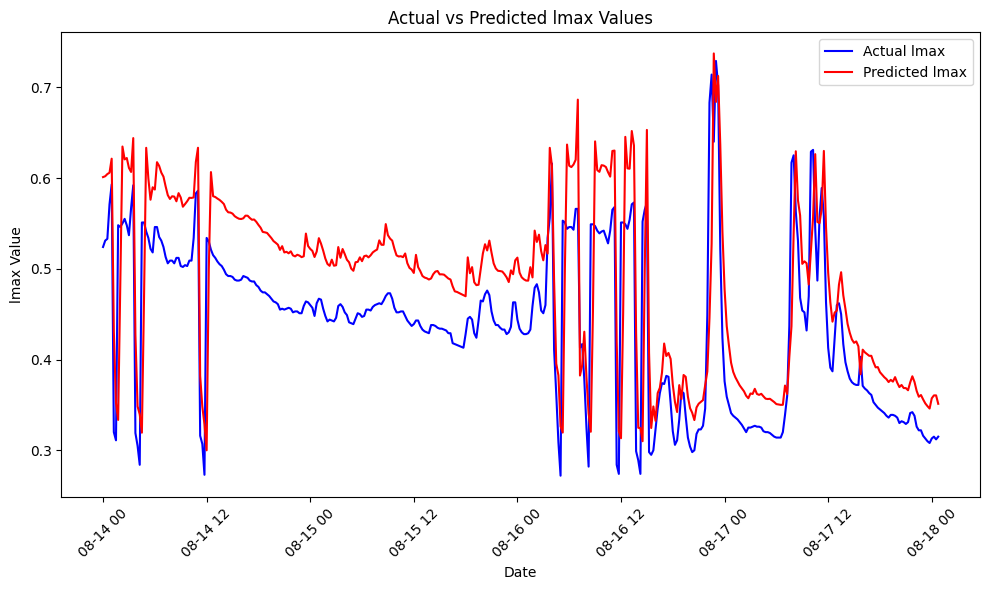

In [56]:
def plot_aggregated_predictions(test_generator, model_predictions, scaler, original_df, n_output, feature_index, split_index, n_input):
    """
    Plots aggregated model predictions against actual values for the entire test dataset,
    taking into consideration the specific feature index for inverse transformation.

    Parameters:
    - test_generator: The generator used for testing the model.
    - model_predictions: Predictions made by the model on the test_generator.
    - scaler: MinMaxScaler instance used to scale the dataset.
    - original_df: Original DataFrame used for the model training and testing.
    - n_output: Number of steps predicted by the model in each sequence.
    - feature_index: Index of the target feature in the original dataset for inverse scaling.
    - split_index: The index where the test data starts in the original DataFrame.
    """
    if model_predictions.ndim > 2:
        model_predictions = model_predictions.reshape(model_predictions.shape[0], -1)
    averaged_predictions = np.mean(model_predictions, axis=1)

    print(f"Model predictions reshaped: {model_predictions.shape}")
    print(f"Averaged predictions: {averaged_predictions.shape}")
    
    # Prepare the dummy array for inverse scaling
    dummy_array = np.zeros((len(averaged_predictions), original_df.shape[1]))
    dummy_array[:, feature_index] = averaged_predictions


    prediction_start_index = split_index + n_input
    prediction_end_index = prediction_start_index + len(averaged_predictions)
    # Inverse transform the dummy array
    predictions_inverse = scaler.inverse_transform(dummy_array)[:, feature_index]
    
    # Trim the prediction data by the initial input of n_input data points. 
    predictions_inverse = predictions_inverse[n_input:]


    print(f"Prediction start index: {prediction_start_index}")
    print(f"Prediction end index: {prediction_end_index}")
    # Prepare the actual values
    # actuals = original_df.iloc[split_index + len(test_generator) - len(averaged_predictions):split_index + len(test_generator), feature_index]
    actuals = original_df.iloc[prediction_start_index:prediction_end_index][original_df.columns[feature_index]]
    print(f"Actuals length: {len(actuals)}")

    # Correctly calculate the start date for the test data predictions
    # This accounts for the 'length' of the test_generator sequences
    test_data_start_date = df.index[prediction_start_index]
    print(f"Test data start date: {test_data_start_date}")


    end_date = df.index[-1]
    
    # Calculate the date range
    date_range_length = pd.date_range(start=test_data_start_date, end=end_date)
    
    # Print the length of the date range
    print(f"Length of date range: {len(date_range_length)}")
    # Generate the date range for plotting, adjusted for the length of averaged_predictions
    prediction_dates = pd.date_range(start=test_data_start_date, periods=actuals.shape[0], freq='15min')
    print(f"Prediction dates length: {len(prediction_dates)}")
    print(f"Length of predictions_inverse: {len(predictions_inverse)}")

    # Plotting code remains the same...
    plt.figure(figsize=(10, 6))
    plt.plot(prediction_dates, actuals.values, label='Actual lmax', color='blue')
    plt.plot(prediction_dates, predictions_inverse, label='Predicted lmax', color='red')
    plt.title('Actual vs Predicted lmax Values')
    plt.xlabel('Date')
    plt.ylabel('lmax Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'df' is your original dataframe and 'scaler' is your MinMaxScaler instance
# predictions = model.predict(test_generator)  # Model predictions
# Ensure the feature index is correctly identified
feature_index = df.columns.get_loc('lmax')  # Adjust 'lmax' to the column you need

# Ensure the split index accurately reflects where your test data starts
split_index = len(df) - len(predictions)  # Adjust based on how you have prepared the data
plot_aggregated_predictions(prediction_generator, predictions, scaler, df_filled.tail(500),7, feature_index,56, n_input)
